In [1]:
# import libraries
try:
  # %tensorflow_version only exists in Colab.
  !pip install tf-nightly
except Exception:
  pass
import tensorflow as tf
import pandas as pd
from tensorflow import keras
!pip install tensorflow-datasets
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 589.4 MB 20 kB/s 
     |████████████████████████████████| 6.0 MB 22.1 MB/s 
     |████████████████████████████████| 439 kB 44.1 MB/s 
     |████████████████████████████████| 1.7 MB 40.5 MB/s 
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.2 requires flatbuffers<2,>=1.12, but you have flatbuffers 22.9.24 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
2.11.0-dev20221013


In [2]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
!wget https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv

train_file_path = "train-data.tsv"
test_file_path = "valid-data.tsv"

--2022-10-13 13:23:53--  https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.3.33, 104.26.2.33, 172.67.70.149, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.3.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 358233 (350K) [text/tab-separated-values]
Saving to: ‘train-data.tsv’

train-data.tsv      100%[===================>] 349.84K  --.-KB/s    in 0.05s   

2022-10-13 13:23:53 (7.18 MB/s) - ‘train-data.tsv’ saved [358233/358233]

--2022-10-13 13:23:53--  https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.3.33, 104.26.2.33, 172.67.70.149, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.3.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 118774 (116K) [text/tab-separated-values]
Saving to: ‘valid-data.tsv’

valid-data.tsv      100%[==============

In [33]:
df_train = pd.read_csv(train_file_path, sep="\t", header=None, names=['y', 'x'])
df_train.head()

,y,x
0,ham,ahhhh...just woken up!had a bad dream about u ...
1,ham,you can never do nothing
2,ham,"now u sound like manky scouse boy steve,like! ..."
3,ham,mum say we wan to go then go... then she can s...
4,ham,never y lei... i v lazy... got wat? dat day ü ...


In [34]:
df_test = pd.read_csv(test_file_path, sep="\t", header=None, names=['y', 'x'])
df_test.head()

,y,x
0,ham,i am in hospital da. . i will return home in e...
1,ham,"not much, just some textin'. how bout you?"
2,ham,i probably won't eat at all today. i think i'm...
3,ham,don‘t give a flying monkeys wot they think and...
4,ham,who are you seeing?


In [35]:
y_train = df_train['y'].astype('category').cat.codes
y_test  = df_test['y'].astype('category').cat.codes
y_train[:5]

0    0
1    0
2    0
3    0
4    0
dtype: int8

# **Text Processing**

In [41]:
import nltk
nltk.download('stopwords') # download stopwords
nltk.download('wordnet')   # download vocab for lemmatizer
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [37]:
import re
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords

In [38]:
stopwords_eng = set(stopwords.words('english'))
len(stopwords_eng)

179

In [39]:
lemmatizer = WordNetLemmatizer()

def clean_txt(txt):
    txt = re.sub(r'([^\s\w])+', ' ', txt)
    txt = " ".join([lemmatizer.lemmatize(word) for word in txt.split()
                    if not word in stopwords_eng])
    txt = txt.lower()
    return txt

In [42]:
X_train = df_train['x'].apply(lambda x: clean_txt(x))
X_train[:5]

0    ahhhh woken bad dream u tho dont like u right ...
1                                        never nothing
2    u sound like manky scouse boy steve like trave...
3    mum say wan go go shun bian watch da glass exh...
4    never lei v lazy got wat dat day ü send da url...
Name: x, dtype: object

# **Vectorize**

In [48]:
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

In [44]:
# Keep top 1000 frequently occurring words
max_words = 1000

# Cut off the words after seeing 500 words in each document
max_len = 500

t = Tokenizer(num_words=max_words)
t.fit_on_texts(X_train)

In [45]:
# Transform each text to a sequence of integers
sequences = t.texts_to_sequences(X_train)
sequences[:5]

[[309, 227, 1, 587, 42, 15, 1, 90, 359, 13, 103, 54, 228, 86],
 [195, 252],
 [1, 310, 15, 219, 15, 43, 311, 37, 386, 1, 6, 338, 422],
 [477, 58, 188, 8, 8, 243, 43],
 [195, 478, 167, 821, 18, 77, 212, 12, 28, 22, 43, 124, 70, 24]]

In [50]:
# Make all rows of equal length
sequences_matrix = pad_sequences(sequences, maxlen=max_len)
sequences_matrix[:5]

array([[  0,   0,   0, ...,  54, 228,  86],
       [  0,   0,   0, ...,   0, 195, 252],
       [  0,   0,   0, ...,   6, 338, 422],
       [  0,   0,   0, ...,   8, 243,  43],
       [  0,   0,   0, ..., 124,  70,  24]], dtype=int32)

# **Model**

In [51]:
i = tf.keras.layers.Input(shape=[max_len])
x = tf.keras.layers.Embedding(max_words, 50, input_length=max_len)(i)
x = tf.keras.layers.LSTM(64)(x)

x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(1, activation='relu')(x)

model = tf.keras.models.Model(inputs=i, outputs=x)
model.compile(
    loss='binary_crossentropy',
    optimizer='RMSprop',
    metrics=['accuracy']
)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 500)]             0         
                                                                 
 embedding_3 (Embedding)     (None, 500, 50)           50000     
                                                                 
 lstm_5 (LSTM)               (None, 64)                29440     
                                                                 
 dense_6 (Dense)             (None, 256)               16640     
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                 257       
                                                                 
Total params: 96,337
Trainable params: 96,337
Non-trainable p

In [52]:
r = model.fit(sequences_matrix, y_train,
              batch_size=128, epochs=10,
              validation_split=0.2,
              callbacks=[tf.keras.callbacks.EarlyStopping(
                  monitor='val_loss', min_delta=0.0001)])

Epoch 1/10
27/27 [==============================] - 31s 987ms/step - loss: 0.3762 - accuracy: 0.8774 - val_loss: 0.1527 - val_accuracy: 0.9713
Epoch 2/10
27/27 [==============================] - 26s 970ms/step - loss: 0.1423 - accuracy: 0.9722 - val_loss: 0.0810 - val_accuracy: 0.9880


# **Evaluate**

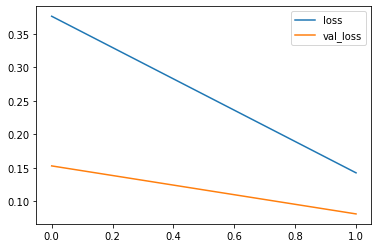

In [53]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

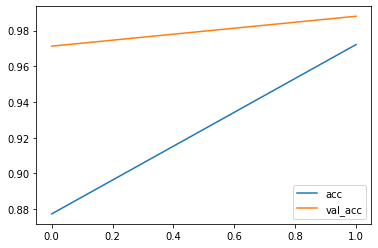

In [54]:
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()

In [56]:
def preprocessing(X):
  x = X.apply(lambda x: clean_txt(x))
  x = t.texts_to_sequences(x)
  return pad_sequences(x, maxlen=max_len)

In [57]:
s = model.evaluate(preprocessing(df_test['x']), y_test)

44/44 [==============================] - 3s 78ms/step - loss: 0.0768 - accuracy: 0.9835


In [58]:
print('Loss: {:.3f}, Accuracy: {:.3f}'.format(s[0], s[1]))

Loss: 0.077, Accuracy: 0.983


In [59]:
# function to predict messages based on model
# (should return list containing prediction and label, ex. [0.008318834938108921, 'ham'])
def predict_message(pred_text):
  p = model.predict(preprocessing(pd.Series([pred_text])))[0]

  return (p[0], ("ham" if p<0.5 else "spam"))

pred_text = "how are you doing today?"

prediction = predict_message(pred_text)
print(prediction)

1/1 [==============================] - 1s 1s/step
(0.0, 'ham')


In [60]:
# Run this cell to test your function and model. Do not modify contents.
def test_predictions():
  test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460324",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

  test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
  passed = True

  for msg, ans in zip(test_messages, test_answers):
    prediction = predict_message(msg)
    if prediction[1] != ans:
      passed = False

  if passed:
    print("You passed the challenge. Great job!")
  else:
    print("You haven't passed yet. Keep trying.")

test_predictions()


1/1 [==============================] - 0s 41ms/step
You passed the challenge. Great job!
